# MLSVGD example set up

### Author: Terrence Alsup
### Date: March 1st, 2022

Reference: [Multilevel Stein variational gradient descent with applications to Bayesian inverse problems](https://msml21.github.io/papers/id52.pdf), T. Alsup, L. Venturi, and B. Peherstorfer (2021).


__Notes__
1. This code closely follows the original SVGD implementation by Dilin Wang, see https://github.com/dilinwang820/Stein-Variational-Gradient-Descent

2. Each of the SVGD and MLSVGD algorithms at the end may take about 10 minutes each to run on a laptop.

3. This should work with most versions of Python 3.

In [1]:
from MLSVGD import MLSVGD
from forward_model import solveDiffusionEq

import numpy as np
from scipy.stats import multivariate_normal as mvnrnd
from scipy.spatial.distance import mahalanobis
from matplotlib import pyplot as plt

# Forward model: Steady-state diffusion

Consider a steady-state diffusion over the interval $[0,1]$ governed by the differential equation

$$
    -\frac{d}{dx}\left( \exp(a(x;\theta)) \frac{d}{dx} u(x;\theta) \right) = 1 \, ,
$$

where the solution $u(x;\theta)$ represents the heat at a point $x \in [0,1]$ in the domain and depends on the parameter $\theta \in \mathbb{R}^d$ through the log-diffusivity coefficient $a(x;\theta)$

$$
    a(x;\theta) = \theta_0 + \theta_1 x + \cdots + \frac{\theta_{d-1}}{(d-1)!} x^{d-1} \, .
$$

The boundary conditions are $u(0;\theta) = 0$ and $u(1;\theta) = 1$.  The parameter-to-observable map is the solution $u(x;\theta)$ evaluated at $p$ equally-spaced grid points $u(x_i;\theta)$, where $x_i = i/(p+1)$ for $i=1,\ldots,p$.

The function `solveDiffusionEq()` in the file `forward_model.py` implements this parameter-to-observable map by approximating the solution $u$ with a finite difference method.  In this example, we take $d=2$ so that we can visualize the samples $\theta$ and posterior distribution.  For the number of observation points we take $p=20$.

For the high-fidelity model we solve the equation above with 1024 grid points and for the two low-fidelity models we solve the equation with 16 and 64 grid points.  We denote the high-fidelity parameter-to-observable map as $G^{(L)} : \mathbb{R}^d \to \mathbb{R}^p$.

In [2]:
# Set the dimension of the parameters and observations
d = 2
p = 20

In [3]:
# Set up a high-fidelity and two low-fidelity parameter-to-observable maps
G_high = lambda z: solveDiffusionEq(z, 1024, p)[0]

G_low1 = lambda z: solveDiffusionEq(z, 16, p)[0]
G_low2 = lambda z: solveDiffusionEq(z, 64, p)[0]

We assume that we obtain noisy data $y \in \mathbb{R}^{p}$ ($p=20$) by computing the solution $u$ using the zero vector $[0,0]^{\top} \in \mathbb{R}^2$ as the parameters with the finite difference method using 2048 grid points.  Finally, we add i.i.d. Gaussian noise with mean zero and covariance matrix $\Gamma = 10^{-3} {\mathbf{I}}_{p\times p}$, where $\mathbf{I}_{p\times p}$ is the identity matrix.

In [4]:
# Set the noise covariance
noise_covariance = 1e-3*np.eye(p)

# Generate a noisy data observation
z0  = np.zeros(d)  # Corresponds to constant 1 diffusivity

# True solution and observation
Gz0, u0 = solveDiffusionEq(z0, 2048, p)  
# Note that we set the random state in this case to result in the same posteriors over different runs.
y = Gz0 + mvnrnd.rvs(mean=np.zeros(p), cov=noise_covariance, random_state=7)

## Plotting the observations and the true solution

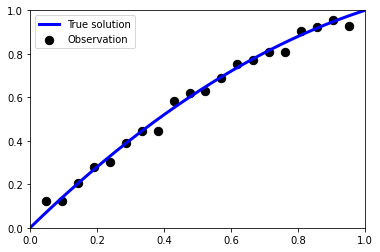

In [5]:
# Observation points
x_obs = np.linspace(0, 1, p+2)[1:p+1]

# Plot the true solution and the noisy observations
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(np.linspace(0, 1, len(u0)), u0, c='b', lw=3, label='True solution')
ax.scatter(x_obs, y, marker='o', c='k', s=70, label='Observation')
ax.legend();

# Bayesian inverse problem

We can set up a Bayesian inverse problem by specificing a prior distribution $\pi_0$ over the parameter $\theta$.  The posterior distribution $\pi^{(L)}$ at level $L$ is then proportional to

$$
    \pi^{(L)}(\theta) \propto \exp\left(-\frac{1}{2}\| y - G^{(L)}(\theta) \|_{\Gamma^{-1}} \right) \pi_0(\theta)
$$

For this example we set the prior to be a Gaussian distribution with zero mean and covariance $0.5 \times \mathbf{I}_{2\times 2}$.

In [6]:
# Set a prior over the parameters
prior_mean = np.zeros(d)
prior_cov  = 5e-1*np.eye(d)
prior = mvnrnd(mean=prior_mean, cov=prior_cov)

noise_precision = 1e3*np.eye(p) # Change this if the noise covariance was changed earlier

In [7]:
# Set up the log-likelihoods for the high-fidelity and two low-fidelity models
loglike_high = lambda z: -0.5*mahalanobis(G_high(z), y, noise_precision)**2
loglike_low1 = lambda z: -0.5*mahalanobis(G_low1(z), y, noise_precision)**2
loglike_low2 = lambda z: -0.5*mahalanobis(G_low2(z), y, noise_precision)**2

In [8]:
# Set up the log-posteriors
logprob_high = lambda z: loglike_high(z) + prior.logpdf(z)
logprob_low1 = lambda z: loglike_low1(z) + prior.logpdf(z)
logprob_low2 = lambda z: loglike_low2(z) + prior.logpdf(z)

## Plotting the posterior distributions

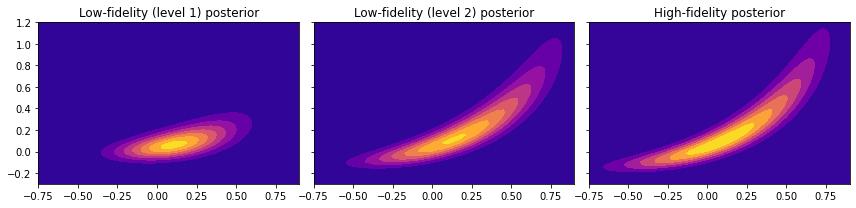

In [9]:
# May need to adjust the grid if the parameters are changed
xx, yy = np.meshgrid(np.linspace(-0.75, 0.9, 60), np.linspace(-0.3, 1.2, 60))

z = np.vstack([xx.flatten(), yy.flatten()]).T
logpz_high = np.apply_along_axis(logprob_high, 1, z).reshape(xx.shape)
logpz_low1 = np.apply_along_axis(logprob_low1, 1, z).reshape(xx.shape)
logpz_low2 = np.apply_along_axis(logprob_low2, 1, z).reshape(xx.shape)

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))
ax[0].contourf(xx, yy, np.exp(logpz_low1), cmap='plasma')
ax[0].set_title('Low-fidelity (level 1) posterior')
ax[1].contourf(xx, yy, np.exp(logpz_low2), cmap='plasma')
ax[1].set_title('Low-fidelity (level 2) posterior')
ax[2].contourf(xx, yy, np.exp(logpz_high), cmap='plasma')
ax[2].set_title('High-fidelity posterior')
plt.tight_layout()

# Inference with SVGD and MLSVGD

Both the SVGD and MLSVGD algorithms require the gradients of the log density (score function)

$$
    s(\theta) = \nabla \log p(\theta) \, .
$$

For many inverse problems with an underlying differential equation one can use the adjoint method or automatic differentiation to compute these gradients exactly.  However, for many black box models one needs to resort to finite difference approximations of the gradient.

In [10]:
def fd_gradient(fun, z, eps=1e-4):
    """
    Returns a callable that evaluates the finite-difference gradient
    using step size eps.
    """
    d = len(z)
    g = np.zeros(d)
    for i in range(d):
        ei = np.zeros(d)
        ei[i] = 1.0
        g[i] = (fun(z + eps*ei) - fun(z - eps*ei))/(2*eps)
    return g

# Set up the gradients of the log posteriors using centered finite-differences
gradlogprob_high = lambda z: fd_gradient(logprob_high, z)
gradlogprob_low1 = lambda z: fd_gradient(logprob_low1, z)
gradlogprob_low2 = lambda z: fd_gradient(logprob_low2, z)

In [11]:
# Sample initial particles (can be according to the prior or some other distribution)
theta0 = mvnrnd.rvs(mean=np.zeros(d), cov=1e-1*np.eye(d), size=500)

## SVGD
To run SVGD using only a single level define a Python dictionary where the key corresponds to the level and the value is a callable that evaluates the gradient of the log posterior at a point.  Here we run SVGD using only the high-fidelity model.

In [12]:
# SVGD

# 1. Create dictionary of the models
gradlogprobs = {3:gradlogprob_high}

# 2. Create the MLSVGD object
svgd = MLSVGD(gradlogprobs, theta0, stepsize=1e-2, bandwidth=5e-1, tol=2e-2, max_iters=500, 
              save_file='SVGD_results.pickle')

# 3. Run to obtain results
svgd_results = svgd.run(verbose=25)


Starting level 3

iter = 0,	 runtime [s] = 2.45e+00,	 grad norm = 1.657e+01
iter = 25,	 runtime [s] = 5.88e+01,	 grad norm = 2.464e-01
iter = 50,	 runtime [s] = 1.24e+02,	 grad norm = 1.518e-01
iter = 75,	 runtime [s] = 1.90e+02,	 grad norm = 1.059e-01
iter = 100,	 runtime [s] = 2.56e+02,	 grad norm = 7.368e-02
iter = 125,	 runtime [s] = 3.21e+02,	 grad norm = 5.227e-02
iter = 150,	 runtime [s] = 3.85e+02,	 grad norm = 3.839e-02
iter = 175,	 runtime [s] = 4.48e+02,	 grad norm = 2.946e-02
iter = 200,	 runtime [s] = 5.09e+02,	 grad norm = 2.342e-02

MLSVGD completed

Results saved at	SVGD_results.pickle



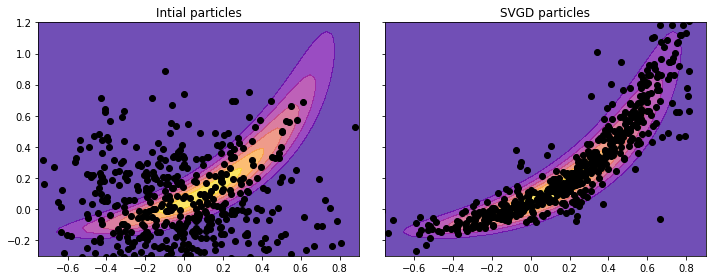

In [13]:
# Get both the final and initial particles and plot the results
x = svgd_results['particles']
x0 = svgd_results['initial_particles']

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))

ax[0].contourf(xx, yy, np.exp(logpz_high), cmap='plasma', alpha=0.7)
ax[0].scatter(x0[:,0], x0[:,1], c='k')
ax[0].set_xlim([-0.75, 0.9])
ax[0].set_ylim([-0.3, 1.2])
ax[0].set_title('Intial particles')

ax[1].contourf(xx, yy, np.exp(logpz_high), cmap='plasma', alpha=0.7)
ax[1].scatter(x[:,0], x[:,1], c='k')
ax[1].set_xlim([-0.75, 0.9])
ax[1].set_ylim([-0.3, 1.2])
ax[1].set_title('SVGD particles')

plt.tight_layout()

## MLSVGD

In [14]:
# MLSVGD

# 1. Create dictionary of the models
gradlogprobs = {1:gradlogprob_low1, 2:gradlogprob_low2, 3:gradlogprob_high}

# 2. Create the MLSVGD object
mlsvgd = MLSVGD(gradlogprobs, theta0, stepsize=1e-2, bandwidth=5e-1, tol=2e-2, max_iters=500)

# 3. Run to obtain results
mlsvgd_results = mlsvgd.run(verbose=25)


Starting level 1

iter = 0,	 runtime [s] = 1.74e+00,	 grad norm = 1.804e+01
iter = 25,	 runtime [s] = 3.76e+01,	 grad norm = 1.140e-01
iter = 50,	 runtime [s] = 7.24e+01,	 grad norm = 2.942e-02

Starting level 2

iter = 0,	 runtime [s] = 8.65e+01,	 grad norm = 4.491e+00
iter = 25,	 runtime [s] = 1.24e+02,	 grad norm = 2.539e-01
iter = 50,	 runtime [s] = 1.61e+02,	 grad norm = 1.506e-01
iter = 75,	 runtime [s] = 1.98e+02,	 grad norm = 9.758e-02
iter = 100,	 runtime [s] = 2.36e+02,	 grad norm = 6.520e-02
iter = 125,	 runtime [s] = 2.76e+02,	 grad norm = 4.538e-02
iter = 150,	 runtime [s] = 3.16e+02,	 grad norm = 3.346e-02
iter = 175,	 runtime [s] = 3.54e+02,	 grad norm = 2.569e-02
iter = 200,	 runtime [s] = 3.91e+02,	 grad norm = 2.023e-02

Starting level 3

iter = 0,	 runtime [s] = 3.97e+02,	 grad norm = 1.933e+00
iter = 25,	 runtime [s] = 4.59e+02,	 grad norm = 5.579e-02
iter = 50,	 runtime [s] = 5.17e+02,	 grad norm = 3.346e-02
iter = 75,	 runtime [s] = 5.76e+02,	 grad norm = 2.065e-

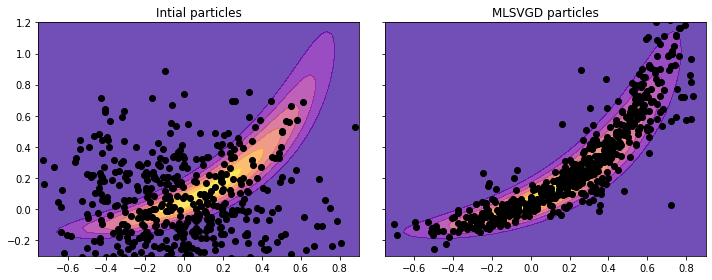

In [15]:
x = mlsvgd_results['particles']
x0 = mlsvgd_results['initial_particles']

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))

ax[0].contourf(xx, yy, np.exp(logpz_high), cmap='plasma', alpha=0.7)
ax[0].scatter(x0[:,0], x0[:,1], c='k')
ax[0].set_xlim([-0.75, 0.9])
ax[0].set_ylim([-0.3, 1.2])
ax[0].set_title('Intial particles')

ax[1].contourf(xx, yy, np.exp(logpz_high), cmap='plasma', alpha=0.7)
ax[1].scatter(x[:,0], x[:,1], c='k')
ax[1].set_xlim([-0.75, 0.9])
ax[1].set_ylim([-0.3, 1.2])
ax[1].set_title('MLSVGD particles')

plt.tight_layout()

## Runtime comparison of MLSVGD and SVGD

After calling the `run()` method from the `MLSVGD` class, a Python dictionary is returned containing useful diagnostic information such as the cumulative runtime from each iteration and the average norm of the gradient at each particle.  The cell below compares SVGD and MLSVGD by both total iterations taken as well as total computational cost.

Because the runtime depends on the implementation, computer architecture, and any background processes running we will compare the computational cost of each method.  Since the high-fidelity model solves the differential equation using 64 and 16 as many grid points as the low-fidelity models, respectively we will set the computational cost of each model to be

$$
\mathrm{cost}_{\mathrm{low-1}} = 1,\quad \mathrm{cost}_{\mathrm{low-2}} = 4,\quad \mathrm{cost}_{\mathrm{high}} = 64 \, ,
$$

and then compute the total computational cost of SVGD and MLSVGD by multiplying the computational cost for each model times the number of iterations spent at that level.  Note that the scaling is linear because the discretized differential equation results in a sparse (tri-diagonal) system of linear equations, which can be solved in linear time.

In [16]:
# Compute computational costs
svgd_cost = 64*svgd_results['total_iters']


# Compute MLSVGD cost
total_iters = mlsvgd_results['total_iters'][-1]

# Get the vector of costs
mlsvgd_cost = []

cost = 0
for i in range(total_iters+1):
    # Check what the level was
    L = mlsvgd_results['levels'][i]
    if L == 1:
        cost = cost + 1
    elif L == 2:
        cost = cost + 4
    elif L == 3:
        cost = cost + 64
    mlsvgd_cost.append(cost)

mlsvgd_cost = np.array(mlsvgd_cost)

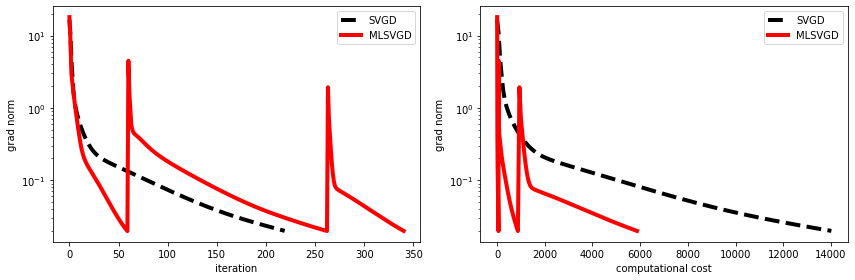

In [17]:
# Plot the gradient norms against computational costs and iterations 
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(svgd_results['total_iters'], svgd_results['grad_norm'], 'k--', lw=4, label='SVGD')
ax[0].plot(mlsvgd_results['total_iters'], mlsvgd_results['grad_norm'], 'r', lw=4, label='MLSVGD')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('grad norm')


ax[1].plot(svgd_cost, svgd_results['grad_norm'], 'k--', lw=4, label='SVGD')
ax[1].plot(mlsvgd_cost, mlsvgd_results['grad_norm'], 'r', lw=4, label='MLSVGD')
ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlabel('computational cost')
ax[1].set_ylabel('grad norm')

plt.tight_layout()